In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time

random.seed(33)

unique_name = "BERT_with_Bigram"

In [2]:
data = pd.read_csv("../../data/processed/twitter15_dataset_with_tvt.csv", lineterminator="\n")
data.head()

,tweet_id,tweet_text,label,tvt,cv_fold,tt,tvt2
0,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified,training,1,training,training
1,714598641827246081,an open letter to trump voters from his top st...,unverified,training,1,test,training
2,691809004356501505,america is a nation of second chances —@potus ...,non-rumor,training,2,training,training
3,693204708933160960,"brandon marshall visits and offers advice, sup...",non-rumor,training,1,training,training
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,true,training,3,training,training


In [3]:
texts = data['tweet_text'].tolist()
texts[:10]

['🔥ca kkk grand wizard 🔥 endorses @hillaryclinton #neverhillary #trump2016 URL\r',
 'an open letter to trump voters from his top strategist-turned-defector URL via @xojanedotcom\r',
 'america is a nation of second chances —@potus on new reforms to solitary confinement: URL URL\r',
 'brandon marshall visits and offers advice, support to brother of fallen hero zaevion dobson: URL URL\r',
 'rip elly may clampett: so sad to learn #beverlyhillbillies star donna douglas has passed away. URL\r',
 'former 3 doors down guitarist matt roberts has died at age 38, according to his father. URL URL\r',
 'craigslist ad: ‘get paid $15 an hour to protest at the trump rally’ - URL URL\r',
 'just in: missing afghan soldiers found trying to enter canada near niagara falls URL URL\r',
 'the day #ferguson cops told a dirty, bloody lie (via @thedailybeast): URL URL\r',
 "#riphulkhogan my heart is ripping like your shirt. wwe'll miss you.\r"]

In [4]:
labels_str = data['label'].unique().tolist()
labels_str

['unverified', 'non-rumor', 'true', 'false']

In [5]:
labels = []
for i, d in data.iterrows():
    lab = labels_str.index(d['label'])
#     labels.append([1 if j == lab else 0 for j in range(len(labels_str))])
    labels.append(lab)
labels[:10]

[0, 0, 1, 1, 2, 1, 0, 2, 0, 3]

In [6]:
bigram_data = pd.read_excel('../../data/processed/twitter15_ngram_distribution.xlsx', sheet_name='bigram')
bigram_data.head()

,Unnamed: 0,unverified,non-rumor,true,false
0,ca kkk,1,0,0,0
1,kkk grand,1,0,0,0
2,grand wizard,1,0,0,0
3,wizard endorses,1,0,0,0
4,endorses @hillaryclinton,1,0,0,0


In [7]:
bigram_probability = {}
for i, d in bigram_data.iterrows():
    bigram_probability[d[0]] = []
    sum_of = 0
    for l in labels_str:
        bigram_probability[d[0]].append(d[l])
        sum_of += d[l]
    
    for i, bp in enumerate(bigram_probability[d[0]]):
        bigram_probability[d[0]][i] = bp/sum_of

bigram_probability['wizard endorses']

[1.0, 0.0, 0.0, 0.0]

In [8]:
import string
import nltk
from sentence_transformers import SentenceTransformer
from sentence_transformers.models import Pooling
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer(reduce_len=True)
model = SentenceTransformer('bert-base-uncased')
pooling_layer = Pooling(768)


def text2bigrams(text):
    bigrams = tokenizer.tokenize(text.encode('ascii', 'ignore').decode('utf8'))
    bigrams = [t for t in bigrams if t not in string.punctuation]
    bigrams = [t for t in bigrams if t not in ['URL', '‘', '’']]
    
    bigrams = nltk.bigrams(bigrams)
    bigrams = map(' '.join, bigrams)
    bigrams = [bgr for bgr in bigrams]
    
    return bigrams


def bigrams2vectors(bigrams):
    vectors = model.encode(bigrams)
    return vectors


def vectors_with_bigrams(text):
    bigrams = text2bigrams(texts[9])
    base_vecs = bigrams2vectors(bigrams)
    embeddings = base_vecs
#     embeddings = []
    
#     for i, vec in enumerate(base_vecs):
#         embeddings.append(vec * max(bigram_probability[bigrams[i]]))
    
    embeddings = torch.unsqueeze(torch.Tensor(embeddings), 0)
    
    inputs = {
        'attention_mask': torch.ones(1, len(bigrams)),
        'token_embeddings': embeddings
    }
    result = pooling_layer.forward(inputs)
    result = torch.squeeze(result['sentence_embedding'], 0).cpu().detach().numpy()
    
    return result


def vectors_generation(texts):
    return model.encode(texts)

2021-11-04 11:02:30.324612: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-04 11:02:30.324639: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Some weights of the model checkpoint at /home/romy/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceC

In [9]:
vectors = []
for text in texts:
    vectors.append(vectors_with_bigrams(text))
vectors = np.array(vectors)

# vectors = vectors_generation(texts)
vectors.shape

(1490, 768)

In [10]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [11]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(1017, 768)
(327, 768)
(146, 768)
(1017,)
(327,)
(146,)


In [12]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNClassifier(nn.Module):
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(128),
            nn.Linear(128, n_output),
#             nn.Sigmoid()
        )
        self.criterion = criterion()
        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device
        
        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999))

    def forward(self, input):
        return self.model(input)
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        best_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            correct = 0
            total = 0
            for batch_idx, (inputs, targets) in enumerate(trainloader):
                self.model.zero_grad()
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)

                try:
                    loss = self.criterion(outputs, targets)
                except Exception:
                    loss = self.criterion(outputs, targets.long())

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                total += targets.size(0)
                
            train_losses.append(train_loss)

            self.model.eval()
            test_loss = 0
            test_acc = 0
            with torch.no_grad():
                inputs, targets = test_x.to(self.device), test_y.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.long())

                test_loss += loss.item()
                
                preds = self.predict(test_x)
                conf_mat = ConfusionMatrix(
                    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_y]),
                    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds.cpu().numpy()]),
                    binary=False
                )
                conf_mat.evaluate(logs=False)
                test_acc = conf_mat.accuracy

            test_losses.append(test_loss)
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train Loss : {train_loss}, Test Loss : {test_loss}")

            # Save checkpoint.
#             if saves and test_loss < best_loss:
#                 print(f"Saving after new best loss : {test_loss}")
#                 best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/{saves}.pth")
            
            if epoch >= n_iter:
                break

        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

        ax2.plot([i for i in range(len(train_losses))], train_losses, c='b', marker="o", label='Train Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, c='r', marker="o", label='Test Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_xlim(0, len(train_losses))
        ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Loss over time (epoch)")
        ax2.legend(loc='lower right')

        plt.show()
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

In [13]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from library.classification import SKLearnClassification
from library.evaluation import ConfusionMatrix

dataset_name = "Twitter15"

logres_model = LogisticRegression(random_state=0, solver='liblinear', multi_class='ovr', max_iter=10000)
neigh = KNeighborsClassifier(n_neighbors=3)
svm = LinearSVC()

models = [
    SKLearnClassification(logres_model, "Logistic Regression"),
    SKLearnClassification(neigh, "K-Nearest Neighbor"),
    SKLearnClassification(svm, "Support Vector Machine"),
]
# for model in models:
#     print(f"\n--- {model.model_name.upper()} ---")
#     model.train(train_vectors, train_labels, dataset_name)
    
#     print("Validation Set")
#     preds = model.predict(val_vectors)

#     conf_mat = ConfusionMatrix(
#         labels=val_labels,
#         predictions=preds,
#         binary=True
#     )
#     conf_mat.evaluate()
    
#     print("Test Set")
#     preds = model.predict(test_vectors)

#     conf_mat = ConfusionMatrix(
#         labels=test_labels,
#         predictions=preds,
#         binary=False
#     )
#     conf_mat.evaluate(classes=labels_str)

#     print("--- END ---\n")

Multiclass Classification using 4-Layer Linear Network
Using cuda
Saving after new best accuracy : 25.076
-- Epoch 50, Train Loss : 2.7724803686141968, Test Loss : 1.3866060972213745
-- Epoch 100, Train Loss : 2.7724525928497314, Test Loss : 1.3866099119186401
-- Epoch 150, Train Loss : 2.7724355459213257, Test Loss : 1.386613130569458
-- Epoch 200, Train Loss : 2.7724231481552124, Test Loss : 1.3866174221038818
-- Epoch 250, Train Loss : 2.7724119424819946, Test Loss : 1.3866180181503296
-- Epoch 300, Train Loss : 2.772403597831726, Test Loss : 1.3866198062896729
-- Epoch 350, Train Loss : 2.7723971605300903, Test Loss : 1.386621356010437
-- Epoch 400, Train Loss : 2.7723958492279053, Test Loss : 1.3866215944290161
-- Epoch 450, Train Loss : 2.7723861932754517, Test Loss : 1.3866244554519653
-- Epoch 500, Train Loss : 2.77238130569458, Test Loss : 1.3866262435913086
-- Epoch 550, Train Loss : 2.772376537322998, Test Loss : 1.3866277933120728
-- Epoch 600, Train Loss : 2.77237248420715

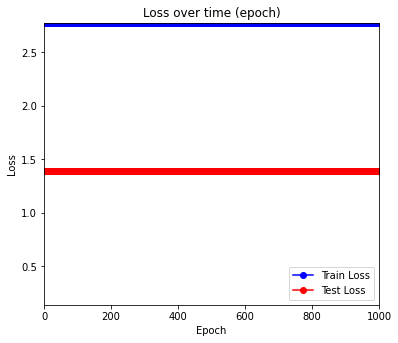

Exec Time : 40.11 seconds

Validation Set
Predictions : torch.Size([327])
327 vs 327
Multi Class Evaluation

Class unverified Evaluation
- Precision : 0 %
- Recall : 0.0 %
- F1 : 0

Class non-rumor Evaluation
- Precision : 25.076 %
- Recall : 100.0 %
- F1 : 0.40098

Class true Evaluation
- Precision : 0 %
- Recall : 0.0 %
- F1 : 0

Class false Evaluation
- Precision : 0 %
- Recall : 0.0 %
- F1 : 0

Combined Evaluation
- Accuracy : 25.076 %
- Precision : 6.269 %
- Recall : 25.0 %
- F1 : 0.10024

- Average Confidence : 100.0 %
Model, Combined,,,,unverified,,,non-rumor,,,true,,,false,,,
Twitter15_4LayerNet_BERT_with_Bigram Validation, 25.076, 6.269, 25.0, 0.10024, 0, 0.0, 0, 25.076, 100.0, 0.40098, 0, 0.0, 0, 0, 0.0, 0, 

Test Set
Predictions : torch.Size([146])
146 vs 146
Multi Class Evaluation

Class unverified Evaluation
- Precision : 0 %
- Recall : 0.0 %
- F1 : 0

Class non-rumor Evaluation
- Precision : 23.288 %
- Recall : 100.0 %
- F1 : 0.37778

Class true Evaluation
- Precision : 0

In [14]:
print("Multiclass Classification using 4-Layer Linear Network")
start = time.time()
model_name = f"Twitter15_4LayerNet_{unique_name}"
model = NNClassifier(train_vectors.shape[1], n_output=4, criterion=nn.CrossEntropyLoss)
model.train_eval(torch.Tensor(train_vectors),
                torch.Tensor(train_labels),
                torch.Tensor(val_vectors),
                torch.Tensor(val_labels),
                saves=model_name,
                n_iter=1000,
                batch_size=512)
print(f"Exec Time : {round(time.time() - start, 2)} seconds")

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\nValidation Set")
preds = model.predict(val_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in val_labels]),
    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds]),
    binary=False,
    model_name=f"{model_name} Validation"
)
conf_mat.evaluate(classes=labels_str)

print("\nTest Set")
preds = model.predict(test_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_labels]),
    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds]),
    binary=False,
    model_name=f"{model_name} Test"
)
conf_mat.evaluate(classes=labels_str)